### What would happen if you ran all the common models and compared them?



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import math 

This is my scoring function, row append sucks but it works, would not reccomend this for large dataframes 

In [2]:
model_metrics = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2"])


def metrics(model, y, y_hat):

    model_metrics.loc[-1] = {"Model" : model, 
              "MSE" : mean_squared_error(y, y_hat),
              "RMSE" : math.sqrt(mean_squared_error(y, y_hat)),
              "R2" : r2_score(y, y_hat)}

    model_metrics.index = model_metrics.index + 1
    return model_metrics 

#metrics("PCA Forest",y_test, epa_pca_y_pred)

Import some data, this is the 2018 EPA Auto dataset about 4000 rows have already been dropped that were useles, you can go backwards in my blog to see what i did and why. I orignally did the data engineering in R, but whatever. https://sqlshep.com/?p=815



In [3]:
epa = pd.read_csv('https://raw.githubusercontent.com/sqlshep/SQLShepBlog/master/data/epaMpg.csv')

In [4]:
epa.head(10)

,RowNumber,Represented.Test.Veh.Make,Model,Vehicle.Type,HorsePower,Cylinders,Tested.Transmission.Type.Code,Tested.Transmission.Type,Gears,Drive.System.Code,Weight,AxleRatio,Test.Procedure.Cd,Test.Procedure.Description,Test.Fuel.Type.Cd,Test.Fuel.Type.Description,FuelEcon
0,1,Aston Martin,Rapide S,Car,552,12,SA,Semi-Automatic,8,R,4750,2.73,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,17.3
1,2,Aston Martin,Vanquish,Car,568,12,SA,Semi-Automatic,8,R,4500,2.73,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,16.5
2,3,BENTLEY,Continental GT,Car,616,12,SA,Semi-Automatic,8,F,6000,2.85,90,US06,61,Tier 2 Cert Gasoline,17.4
3,4,BENTLEY,Continental GT,Car,616,12,SA,Semi-Automatic,8,F,6000,2.85,11,Cold CO,27,Cold CO Premium (Tier 2),13.6
4,5,BMW,230i Convertible,Car,248,4,SA,Semi-Automatic,8,R,4000,2.81,3,HWFE,61,Tier 2 Cert Gasoline,45.8
5,6,BMW,230i Coupe,Car,248,4,M,Manual,6,R,3625,3.91,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,26.4
6,7,BMW,230i Coupe,Car,248,4,SA,Semi-Automatic,8,R,3625,2.81,3,HWFE,61,Tier 2 Cert Gasoline,50.6
7,8,BMW,230i xDrive Convertible,Car,248,4,SA,Semi-Automatic,8,R,4000,2.81,31,Federal fuel 3-day exhaust,61,Tier 2 Cert Gasoline,29.6
8,9,BMW,230i xDrive Coupe,Car,248,4,SA,Semi-Automatic,8,R,3750,2.81,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,30.3
9,10,BMW,320i,Both,181,4,A,Automatic,8,R,3625,3.20,31,Federal fuel 3-day exhaust,61,Tier 2 Cert Gasoline,30.4


In [5]:
epa.shape

(1034, 17)

In [6]:
epa.describe().T


,count,mean,std,min,25%,50%,75%,max
RowNumber,1034.0,521.361702,300.241933,1.00,262.250,520.50,781.75,1040.00
HorsePower,1034.0,291.824952,144.294932,72.00,181.000,271.50,355.00,1500.00
Cylinders,1034.0,5.431335,1.905214,3.00,4.000,4.00,6.00,16.00
Gears,1034.0,6.509671,1.992824,1.00,6.000,7.00,8.00,10.00
Weight,1034.0,4191.852031,787.821434,2375.00,3625.000,4000.00,4750.00,6500.00
AxleRatio,1034.0,3.411064,0.586484,1.56,3.070,3.36,3.70,5.44
Test.Procedure.Cd,1034.0,24.993230,22.078601,2.00,11.000,21.00,31.00,95.00
Test.Fuel.Type.Cd,1034.0,56.366538,11.633650,19.00,61.000,61.00,61.00,61.00
FuelEcon,1034.0,28.216538,9.496233,9.20,21.525,26.80,33.40,71.60


Engineer the dataset a bit, some models dislike periods in the name, drop the first 3 columns, i do not want th emodel to fit to manufacturer and some of the columns are descritptions of other columns so they are dupes. 

In [7]:
#Drop the row number
epa = epa.drop(epa.columns[[0]], axis=1)

#replace the "." in the column names with "_"
epa.columns = epa.columns.str.replace('.', '_')

# Drop the first three columns
epa = epa.drop(epa.columns[[0,1,2]], axis=1)

# drop descrition columns
epa = epa.drop(epa.columns[[3,9,11]], axis=1)
epa



<ipython-input-7-8f3fc07807c6>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  epa.columns = epa.columns.str.replace('.', '_')


,HorsePower,Cylinders,Tested_Transmission_Type_Code,Gears,Drive_System_Code,Weight,AxleRatio,Test_Procedure_Cd,Test_Fuel_Type_Cd,FuelEcon
0,552,12,SA,8,R,4750,2.73,21,61,17.3
1,568,12,SA,8,R,4500,2.73,21,61,16.5
2,616,12,SA,8,F,6000,2.85,90,61,17.4
3,616,12,SA,8,F,6000,2.85,11,27,13.6
4,248,4,SA,8,R,4000,2.81,3,61,45.8
...,...,...,...,...,...,...,...,...,...,...
1029,313,4,SA,8,A,5000,3.33,21,61,33.1
1030,250,4,SA,8,F,5000,3.33,31,61,27.4
1031,250,4,SA,8,F,4750,3.33,31,61,28.6
1032,316,4,SA,8,F,5000,3.33,3,61,37.9


Visualize some stuff, see if there are any patterns. 

<AxesSubplot:xlabel='HorsePower', ylabel='Cylinders'>

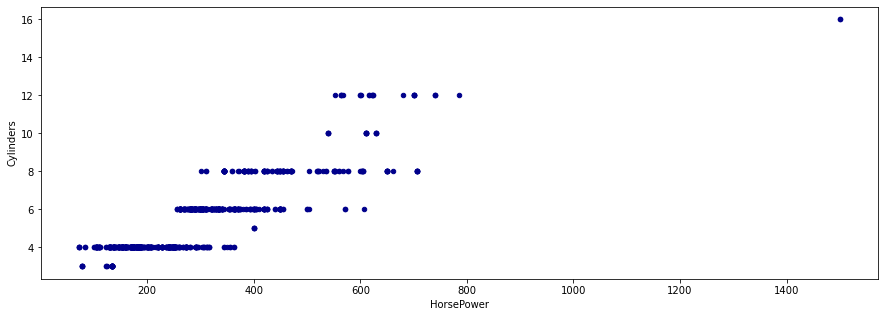

In [8]:
epa.plot.scatter(x='HorsePower',
                      y='Cylinders',
                      c='DarkBlue',
                figsize=(15,5))

<AxesSubplot:xlabel='HorsePower', ylabel='Weight'>

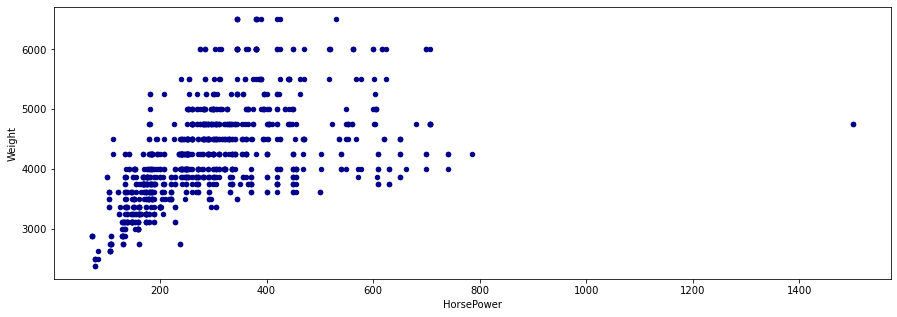

In [9]:
epa.plot.scatter(x='HorsePower',
                      y='Weight',
                      c='DarkBlue',
                figsize=(15,5))

<AxesSubplot:xlabel='HorsePower', ylabel='FuelEcon'>

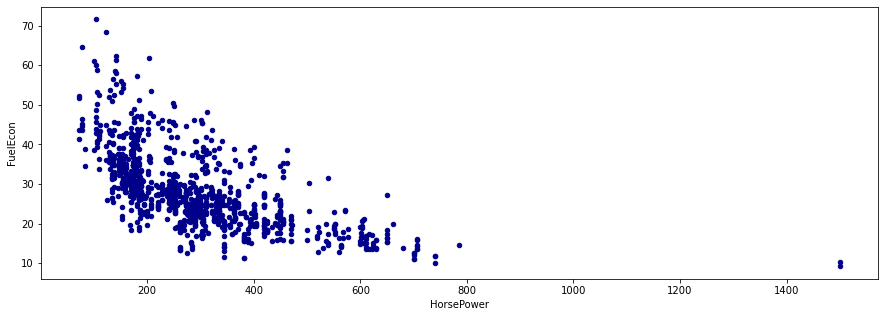

In [10]:
epa.plot.scatter(x='HorsePower',
                      y='FuelEcon',
                      c='DarkBlue',
                figsize=(15,5))

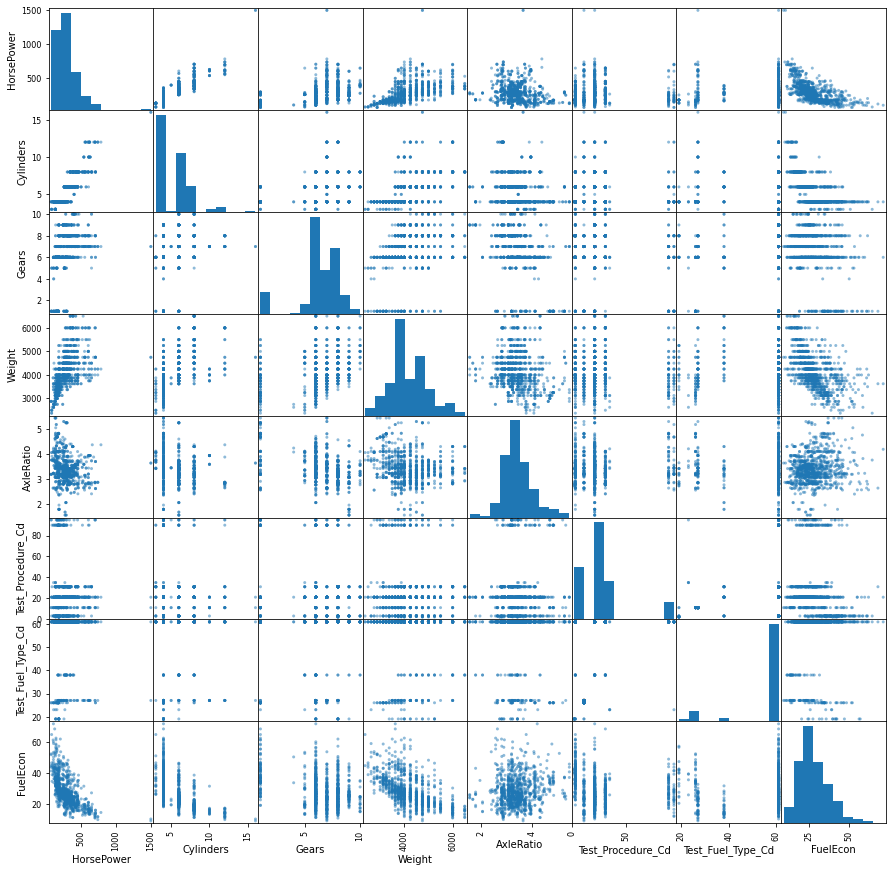

In [11]:
plot = pd.plotting.scatter_matrix(epa,
                figsize=(15,15))



In [12]:
epa.corr()

,HorsePower,Cylinders,Gears,Weight,AxleRatio,Test_Procedure_Cd,Test_Fuel_Type_Cd,FuelEcon
HorsePower,1.000000,0.878153,0.379275,0.523104,-0.183797,-0.058215,0.029944,-0.629558
Cylinders,0.878153,1.000000,0.278601,0.604601,-0.176664,-0.071848,-0.000458,-0.607808
Gears,0.379275,0.278601,1.000000,0.347080,-0.450773,-0.141657,0.150021,-0.336328
Weight,0.523104,0.604601,0.347080,1.000000,-0.200765,-0.057187,0.026476,-0.571316
AxleRatio,-0.183797,-0.176664,-0.450773,-0.200765,1.000000,0.058199,-0.029499,0.124107
Test_Procedure_Cd,-0.058215,-0.071848,-0.141657,-0.057187,0.058199,1.000000,0.225023,-0.164242
Test_Fuel_Type_Cd,0.029944,-0.000458,0.150021,0.026476,-0.029499,0.225023,1.000000,0.064498
FuelEcon,-0.629558,-0.607808,-0.336328,-0.571316,0.124107,-0.164242,0.064498,1.000000


Any correlations? 

<AxesSubplot:>

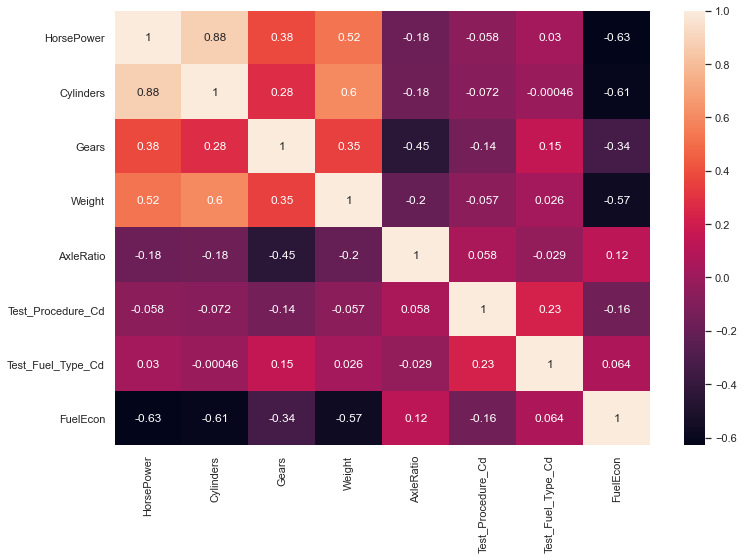

In [13]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(epa.corr(), annot = True)



In [14]:
epa['Tested_Transmission_Type_Code']= epa['Tested_Transmission_Type_Code'].astype('category')
    
epa['Drive_System_Code']= epa['Drive_System_Code'].astype('category')

In [15]:
epa.shape

(1034, 10)

In [16]:
#One hot encode categories
epa = pd.get_dummies(epa)

In [17]:
print(epa.shape)
epa

(1034, 20)


,HorsePower,Cylinders,Gears,Weight,AxleRatio,Test_Procedure_Cd,Test_Fuel_Type_Cd,FuelEcon,Tested_Transmission_Type_Code_A,Tested_Transmission_Type_Code_AM,Tested_Transmission_Type_Code_AMS,Tested_Transmission_Type_Code_CVT,Tested_Transmission_Type_Code_M,Tested_Transmission_Type_Code_SA,Tested_Transmission_Type_Code_SCV,Drive_System_Code_4,Drive_System_Code_A,Drive_System_Code_F,Drive_System_Code_P,Drive_System_Code_R
0,552,12,8,4750,2.73,21,61,17.3,0,0,0,0,0,1,0,0,0,0,0,1
1,568,12,8,4500,2.73,21,61,16.5,0,0,0,0,0,1,0,0,0,0,0,1
2,616,12,8,6000,2.85,90,61,17.4,0,0,0,0,0,1,0,0,0,1,0,0
3,616,12,8,6000,2.85,11,27,13.6,0,0,0,0,0,1,0,0,0,1,0,0
4,248,4,8,4000,2.81,3,61,45.8,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,313,4,8,5000,3.33,21,61,33.1,0,0,0,0,0,1,0,0,1,0,0,0
1030,250,4,8,5000,3.33,31,61,27.4,0,0,0,0,0,1,0,0,0,1,0,0
1031,250,4,8,4750,3.33,31,61,28.6,0,0,0,0,0,1,0,0,0,1,0,0
1032,316,4,8,5000,3.33,3,61,37.9,0,0,0,0,0,1,0,0,0,1,0,0


In [18]:
# Create the training dataset for scikit learn, you will need all varialbes except the labe you are trying to predict
epa_X = epa.iloc[:, epa.columns !='FuelEcon']
#epa_X = epa.iloc[:, epa.columns =='Weight']
epa_X

,HorsePower,Cylinders,Gears,Weight,AxleRatio,Test_Procedure_Cd,Test_Fuel_Type_Cd,Tested_Transmission_Type_Code_A,Tested_Transmission_Type_Code_AM,Tested_Transmission_Type_Code_AMS,Tested_Transmission_Type_Code_CVT,Tested_Transmission_Type_Code_M,Tested_Transmission_Type_Code_SA,Tested_Transmission_Type_Code_SCV,Drive_System_Code_4,Drive_System_Code_A,Drive_System_Code_F,Drive_System_Code_P,Drive_System_Code_R
0,552,12,8,4750,2.73,21,61,0,0,0,0,0,1,0,0,0,0,0,1
1,568,12,8,4500,2.73,21,61,0,0,0,0,0,1,0,0,0,0,0,1
2,616,12,8,6000,2.85,90,61,0,0,0,0,0,1,0,0,0,1,0,0
3,616,12,8,6000,2.85,11,27,0,0,0,0,0,1,0,0,0,1,0,0
4,248,4,8,4000,2.81,3,61,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,313,4,8,5000,3.33,21,61,0,0,0,0,0,1,0,0,1,0,0,0
1030,250,4,8,5000,3.33,31,61,0,0,0,0,0,1,0,0,0,1,0,0
1031,250,4,8,4750,3.33,31,61,0,0,0,0,0,1,0,0,0,1,0,0
1032,316,4,8,5000,3.33,3,61,0,0,0,0,0,1,0,0,0,1,0,0


In [19]:
epa_y = epa.iloc[:, epa.columns =='FuelEcon']

In [20]:
# Split the training and test set 
X_train, X_test, y_train, y_test = train_test_split(epa_X, epa_y, test_size=0.20)

In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(827, 19) (207, 19) (827, 1) (207, 1)


In [22]:
from sklearn import linear_model

epa_lm = regr = linear_model.LinearRegression()

In [23]:
epa_lm.fit(X_train, y_train)

LinearRegression()

In [24]:
epa_y_pred = epa_lm.predict(X_test)

In [25]:
metrics("linear_model",y_test, epa_y_pred)

,Model,MSE,RMSE,R2
0,linear_model,30.82426,5.55196,0.61467


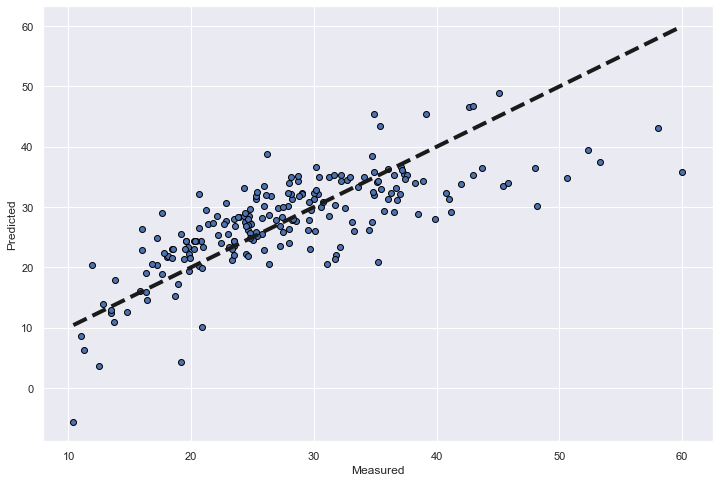

In [26]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(epa_lm, X_test, y_test, cv=5)

fig, ax = plt.subplots()
ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()



# K Nearest Neighbor Regressor


In [27]:
# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsRegressor


In [28]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_y_hat = knn.predict(X_test)

In [29]:
metrics("KNeighborsRegressor",y_test, knn_y_hat)

,Model,MSE,RMSE,R2
1,linear_model,30.824260,5.551960,0.614670
0,KNeighborsRegressor,33.478323,5.786046,0.581492


# Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import graphviz 

In [31]:
epa_forest = RandomForestRegressor()
epa_forest.fit(X_train, y_train)

<ipython-input-31-98d568b2d2b3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  epa_forest.fit(X_train, y_train)


RandomForestRegressor()

In [32]:
forest_y_hat = epa_forest.predict(X_test)

In [33]:
metrics("RandomForestRegressor",y_test, forest_y_hat)

,Model,MSE,RMSE,R2
2,linear_model,30.824260,5.551960,0.614670
1,KNeighborsRegressor,33.478323,5.786046,0.581492
0,RandomForestRegressor,9.148179,3.024596,0.885640


# Gradient Boosting for regression

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
reg = GradientBoostingRegressor(random_state=0)

In [36]:
reg.fit(X_train, y_train)

/Users/shepsheppard/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(random_state=0)

In [37]:
gb_y_hat = reg.predict(X_test)


In [38]:
metrics("GradientBoostingRegressor",y_test, gb_y_hat)

,Model,MSE,RMSE,R2
3,linear_model,30.824260,5.551960,0.614670
2,KNeighborsRegressor,33.478323,5.786046,0.581492
1,RandomForestRegressor,9.148179,3.024596,0.885640
0,GradientBoostingRegressor,9.736517,3.120339,0.878285


# Principal component analysis (PCA)

Ever wondered what PCA would do to your prediction?  

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(epa_X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['V1','V2','V3','V4','V5','V6','V7','V8'])

In [41]:
principalDf

,V1,V2,V3,V4,V5,V6,V7,V8
0,580.917065,204.465064,-1.162797,-4.281176,0.261905,3.593728,0.894035,-0.260253
1,333.677476,244.820274,-1.312308,-4.335153,0.184341,3.569128,0.860145,-0.303424
2,1831.073632,145.570239,68.531820,7.418033,0.118822,2.358438,1.597682,0.381127
3,1831.187473,145.986481,-14.887055,28.347045,0.178735,2.130678,1.613204,0.351619
4,-195.178742,-24.728581,-21.420768,-8.343105,-1.538796,-0.700042,0.063347,-0.766201
...,...,...,...,...,...,...,...,...
1029,806.355021,-57.886470,-2.301236,-4.877282,-1.085470,-2.045797,0.651539,0.096587
1030,800.182760,-120.641828,7.200859,-3.463536,-1.319648,-1.305214,0.801753,0.235416
1031,551.379799,-96.208740,6.957974,-3.562569,-1.436325,-1.163298,0.773071,0.207382
1032,806.676756,-54.794469,-20.051137,-7.748681,-0.765524,-2.069355,0.830734,0.155357


<AxesSubplot:>

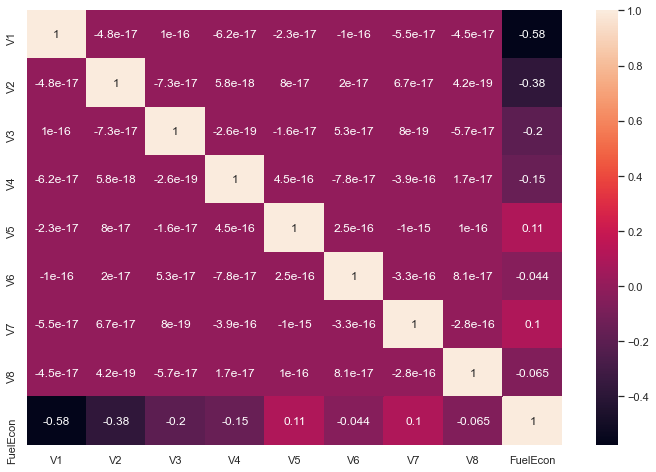

In [42]:
y = pd.DataFrame(epa["FuelEcon"] )
pd.concat([principalDf,y],axis=1)

sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(pd.concat([principalDf,y],axis=1).corr(), annot = True)

In [43]:
epa_forest = RandomForestRegressor()
epa_forest.fit(X_train, y_train)
epa_pca_y_pred = epa_forest.predict(X_test)

<ipython-input-43-1fb136ddb3e2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  epa_forest.fit(X_train, y_train)


In [44]:
metrics("PCA W/ RandomForestRegressor",y_test, epa_pca_y_pred)

,Model,MSE,RMSE,R2
4,linear_model,30.824260,5.551960,0.614670
3,KNeighborsRegressor,33.478323,5.786046,0.581492
2,RandomForestRegressor,9.148179,3.024596,0.885640
1,GradientBoostingRegressor,9.736517,3.120339,0.878285
0,PCA W/ RandomForestRegressor,9.066411,3.011048,0.886662
